In [1]:
from numpy.random import RandomState
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import datasets
from sklearn.datasets import fetch_olivetti_faces

from sklearn import decomposition 


## 数据配置

In [2]:
nPerRow = 10  # plot每行图数目

nFeature = 20    # 目标特征（PCA降维后）数目， 不得大于样本数目n_sample
img_shape_n = 64  # 图像重采样pixel，长=宽
image_shape = (img_shape_n, img_shape_n)
rng = RandomState(0)  # dataset split随机数，如果想要消除随机化，给固定值。

recovery_id = 5  #后续需要恢复的图像id

%matplotlib inline

## Help function

In [3]:
from matplotlib.gridspec import GridSpec

def single_plot(img_array: np.ndarray):
    ''' plot某个图 '''
    fig = plt.figure(figsize=(10, 10))
    ax = plt.subplot2grid((1, 10), (0, 0))
    ax.imshow(img_array.reshape(img_shape_n, img_shape_n), cmap=plt.cm.gray)
    ax.axis('off')


def sub_plot(img_array: np.ndarray, n_components: int, cols: int):
    ''' plot多个子图 '''
    fig = plt.figure(figsize=(10, 10))
    
    # 计算行数并创建GridSpec对象，同时设置较小的间距
    rows = n_components // cols if n_components % cols == 0 else n_components // cols + 1
    gs = GridSpec(rows, cols, hspace=0.1, wspace=0.1)

    for i in range(n_components):
        # 计算当前子图在网格布局中的位置
        row_index = i // cols
        col_index = i % cols
        
        # 在每cols个子图之后换行
        ax = fig.add_subplot(gs[row_index, col_index])
        ax.imshow(img_array[i].reshape(img_shape_n, img_shape_n), cmap=plt.cm.gray)
        
        # 移除所有可能导致额外间距的元素
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.set_frame_on(False)  # 关闭边框


## 数据准备

In [4]:
#faces = datasets.fetch_olivetti_faces()  # 有问题，数据集下不来，
# 基于web方式下载以后，数据（olivettifaces.mat）放在同级别目录下
faces = fetch_olivetti_faces(data_home='./',shuffle=True, random_state=rng)
n_sample, size_sample = faces.data.shape[0], faces.data.shape[1]

print(f"样本数量 = {n_sample}, 每个样本大小 = {size_sample}")
assert n_sample >= nFeature, f"特征数量 {nFeature} 应该小于 样本数量 {n_sample}"


样本数量 = 400, 每个样本大小 = 4096


### plot 前 10 个 样本看看

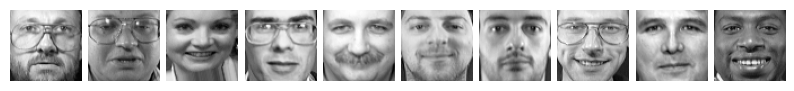

In [5]:
sub_plot(faces.data, 10, nPerRow)

## 数据降维，得到一系列特征脸

In [6]:
# Create a PCA object with the desired number of components
# If n_components was not explicitly set during the creation of the PCA object, the transformed data will have the same number of components as the original data's features.
pca = decomposition.PCA(n_components=nFeature)  #n_components 实际不应该比nFeature大, 

# PCA降维
pca.fit(faces.data)

nFeature_pca, size_feature_pca = pca.components_.shape[0], pca.components_.shape[1]

print(f"PCA降维后特征数量 = {nFeature_pca}，特征向量大小 = {size_feature_pca}")

assert nFeature_pca == nFeature and size_feature_pca==size_sample, f"PCA降维后特征数量 {nFeature_pca} , 特征向量大小 {size_feature_pca} 异常"

PCA降维后特征数量 = 20，特征向量大小 = 4096


## plot所有特征脸来看看

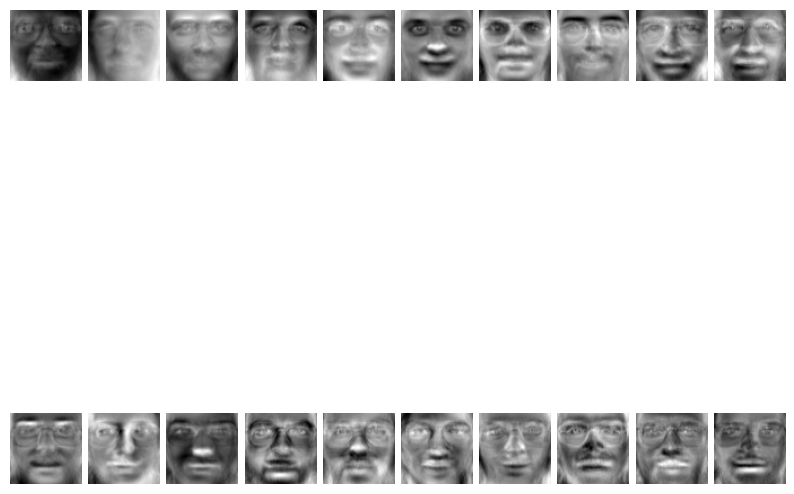

In [7]:
sub_plot(pca.components_, nFeature, nPerRow)

什么是“特征脸”? 就是从已有的所有样本中抽象出来的公共”特征“，这些特征相互之间，应该是几乎没有相似之处的（不相关）
下面可以计算这些特征之间的相似度。

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
feature_similarity = cosine_similarity(pca.components_)
feature_similarity.shape

(20, 20)

In [9]:

np.set_printoptions(precision=3, suppress=True) # 保留小数点后三位

print(feature_similarity)

[[ 1. -0.  0. -0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0. -0. -0.  0. -0.
   0.  0.]
 [-0.  1. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.
   0. -0.]
 [ 0. -0.  1.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0. -0. -0. -0.  0.  0.
   0.  0.]
 [-0.  0.  0.  1.  0.  0. -0.  0. -0.  0.  0.  0. -0.  0. -0. -0. -0.  0.
   0.  0.]
 [ 0. -0.  0.  0.  1.  0.  0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0.
  -0.  0.]
 [ 0.  0. -0.  0.  0.  1. -0. -0.  0.  0. -0. -0.  0.  0.  0.  0.  0.  0.
  -0. -0.]
 [ 0.  0.  0. -0.  0. -0.  1. -0.  0.  0.  0. -0.  0.  0. -0.  0.  0.  0.
  -0.  0.]
 [-0.  0.  0.  0.  0. -0. -0.  1.  0. -0. -0. -0. -0. -0. -0.  0.  0. -0.
   0.  0.]
 [-0.  0.  0. -0.  0.  0.  0.  0.  1. -0.  0.  0.  0. -0.  0. -0. -0. -0.
  -0.  0.]
 [-0.  0. -0.  0. -0.  0.  0. -0. -0.  1. -0.  0. -0.  0. -0. -0.  0. -0.
   0. -0.]
 [-0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  1.  0.  0. -0. -0.  0. -0.  0.
  -0.  0.]
 [ 0.  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  1. -0. -0. -0. -0.

## 拿第一张图片，来做一个特征降维，然后看看这张图片的“特征表达”

### 先抓一张图片，看看原始图片“特征”

原始数据特征维度 = (4096,)
reshaped数据特征维度 = (1, 4096)
[0.207 0.281 0.368 ... 0.252 0.244 0.273]
[[0.207 0.281 0.368 ... 0.252 0.244 0.273]]


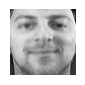

In [11]:
face = faces.data[recovery_id]
single_plot(face) # 看看原始图像数据打印出来什么样子
face_reshaped = face.reshape(1, -1) # 转置为1x4096的向量

print(f"原始数据特征维度 = {face.shape}")
print(f"reshaped数据特征维度 = {face_reshaped.shape}")

# 可以打印出来 face 和 face_reshaped 看看
print(face)
print(face_reshaped)


- face是4096的1D array（等同于64x64的1维平坦化存储表达）,
- face_reshaped = face.reshape(1, -1), 是针对face进行矩阵重新排列操作，1 表示操作后只有1行（行维度为1）， -1：指示numpy自行决定操作后的列维度，
- 因为face是4096的1D array，face_reshaped实际上是（被转置为）1x4096的向量。
- 对于原始图片，可以认为每个pixel都是一个“特征”，因此原始数据我们有4096个特征

### 然后看看上述图片的降维后特征表达

In [12]:
post_pca = pca.transform(face_reshaped) #把 face_reshaped（1x4096）丢到PCA里面去做降维。
print(f"PCA后数据特征维度 = {post_pca.shape}")
print(post_pca)

PCA后数据特征维度 = (1, 20)
[[-5.096 -1.36  -1.934 -2.873 -1.793 -1.89   2.168  1.618 -0.518  0.273
   0.215  0.707 -0.202 -0.365  0.376  2.007 -0.529 -0.514  0.117 -0.375]]


降维后，post_pca是1xnFeature的向量
可以这么理解，post_pca的每个值，就是对应于pca.components_相应特征的权重。
因此，最终我们在PCA之后，使用“降维特征和特征脸”的线性组合来表达对应的图片信息。就是

## 使用特征脸来重建样本

In [13]:
#观察随着使用逐渐增加的特征向量，恢复出来的图像的渐变状况
recovery = []

for i in range(nFeature):
    recovery_every_i = post_pca[:, :i].dot(pca.components_[:i]) + pca.mean_
    recovery.append(recovery_every_i)


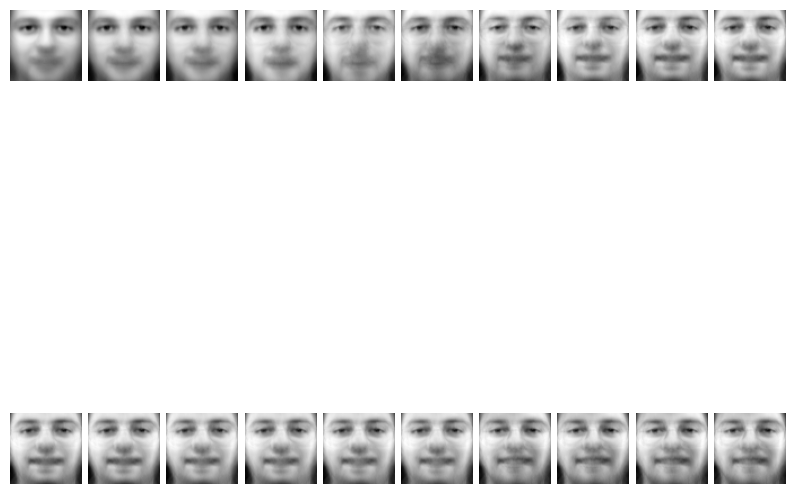

In [14]:
# 随着使用更多的特征，恢复出来的图像质量越来越高。
sub_plot(recovery, nFeature, nPerRow) 

In [16]:
# 把恢复过程的图像存在本地
import os
from skimage.io import imsave
from skimage import img_as_ubyte

# Create a folder named "log" if it doesn't exist
log_folder = "log"
N = nFeature // 5
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

for i in range(nFeature):
    recovery = post_pca[:, :i].dot(pca.components_[:i]) + pca.mean_
    if i % N == 0:  # 并不都存，每N个feature存一次
        # Convert the image data to 'uint8' format
        recovery_uint8 = img_as_ubyte(recovery.reshape(64, 64))
        
        # Save the image in the "log" folder
        filename = os.path.join(log_folder, '{:>03}'.format(str(i)) + '.jpg')
        imsave(filename, recovery_uint8)

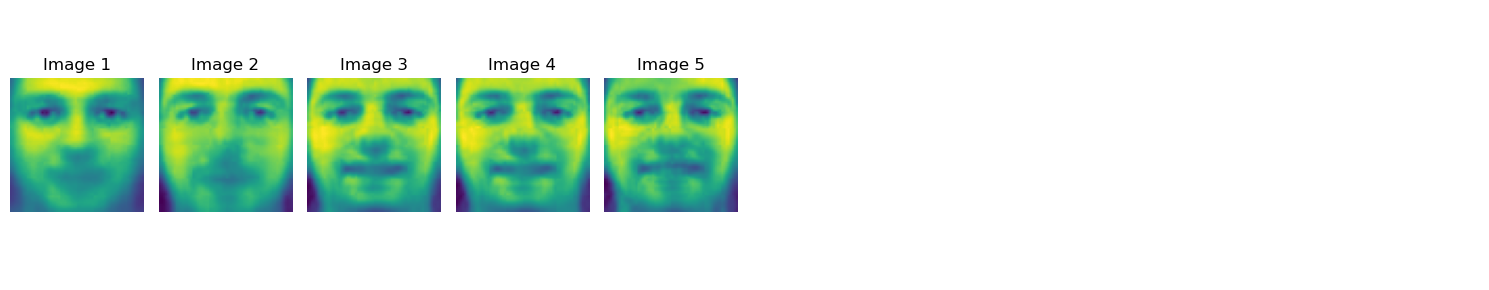

In [20]:
# 把存在本地的图像导出看看
from matplotlib.image import imread
jpeg_files = sorted([file for file in os.listdir(log_folder) if file.endswith(".jpg")])

# Define the number of images per row
images_per_row = 10

# Calculate the number of rows needed
num_images = len(jpeg_files)
num_rows = (num_images + images_per_row - 1) // images_per_row

# Create a large subplot
fig, ax = plt.subplots(num_rows, images_per_row, figsize=(15, 3*num_rows))

# Flatten the axis array to simplify indexing
ax = ax.flatten()

# Display all the images
for i, jpeg_file in enumerate(jpeg_files):
    # Load the image
    image_path = os.path.join(log_folder, jpeg_file)
    image = plt.imread(image_path)

    # Display the image
    ax[i].imshow(image)  # Assuming color images
    ax[i].set_title(f'Image {i+1}')
    ax[i].axis('off')

# Hide any empty subplots
for j in range(num_images, num_rows * images_per_row):
    ax[j].axis('off')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()